<div align="center">
<!-- <h2>Часть по моделированию</h2> -->
<h1>Разработка алгоритмов машинного обучения для прогнозирования поведения киберфизической системы</h1>
<h2>Моделирование</h2>
</div>

### Работа с библиотеками

In [42]:
!pip install scikit-learn pandas seaborn numpy statsmodels scipy


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR 

## Задача от компании Газпром

В задаче нам необходимо предсказать давление на приёме нефтяной скважины, используя 7 следующих параметров:

- диаметр экспл. колонны
- буферное давлениe
- давление в линии
- динамическая высота
- затрубное давление
- обводненность 
- глубина спуска

### Шаг 1. Описательная статистика

In [45]:
df = pd.read_csv("gazprom/data_train.csv") # 4000 индивидов

_df_train, df_test = train_test_split(df, test_size=0.2, random_state=67)

df_train, df_valid = train_test_split(_df_train, test_size=0.2, random_state=67)

df.head()

,Unnamed: 0,Диаметр экспл.колонны,Буферное давление,Давление в линии,Динамическая высота,Затрубное давление,Обводненность,Глубина спуска,Давление на приеме
0,0,150.2,20.1,19.1,2748.0,20.1,32.0,2820.00,26.0
1,1,146.8,23.0,22.0,2520.0,22.0,22.0,2630.00,36.0
2,2,146.8,16.6,15.6,2861.0,16.7,32.0,2957.68,23.0
3,3,146.8,20.0,19.0,2983.0,20.7,70.0,3071.10,23.0
4,4,146.8,9.1,8.1,2525.0,9.9,72.0,2540.00,11.0


In [46]:
df.describe()

,Unnamed: 0,Диаметр экспл.колонны,Буферное давление,Давление в линии,Динамическая высота,Затрубное давление,Обводненность,Глубина спуска,Давление на приеме
count,4000.000000,3992.000000,4000.000000,3999.000000,3995.000000,3995.000000,3997.000000,4000.000000,4000.000000
mean,1999.500000,148.939379,17.238075,15.913603,2500.580776,17.244436,50.276192,2621.475000,26.509950
std,1154.844867,4.622682,5.948660,5.655785,324.227479,5.978479,23.334052,268.544773,16.570177
min,0.000000,129.000000,0.200000,0.100000,21.200000,0.100000,4.000000,1897.920000,2.000000
25%,999.750000,146.800000,14.400000,13.000000,2279.500000,14.000000,30.000000,2380.000000,19.000000
50%,1999.500000,146.800000,17.700000,16.500000,2511.000000,18.000000,48.000000,2614.600000,24.000000
75%,2999.250000,146.800000,20.700000,19.600000,2727.500000,21.200000,69.000000,2812.500000,30.000000
max,3999.000000,159.600000,52.000000,28.200000,3309.000000,34.500000,98.000000,3311.000000,366.000000


# Вывод тестовой выборки
(Не была задействована при обучении)

In [47]:
df_test.head()

,Unnamed: 0,Диаметр экспл.колонны,Буферное давление,Давление в линии,Динамическая высота,Затрубное давление,Обводненность,Глубина спуска,Давление на приеме
2415,2415,146.8,17.7,16.7,2798.0,18.6,30.0,2947.00,27.0
3870,3870,146.8,23.0,22.0,2810.0,24.4,30.0,2877.00,29.0
657,657,150.2,18.0,17.0,2100.0,18.2,54.0,2140.00,23.0
2060,2060,146.8,17.8,16.8,2672.0,18.3,77.0,2933.22,42.0
468,468,146.8,14.0,13.0,2359.0,14.0,68.0,2440.20,21.0


### Шаг 2. Предобработка

Проверяем датасет на пропуски в каждом из признаков.

Исследуем тренировочный датасет:

In [48]:
print(df_train.isna().sum())

Unnamed: 0               0
Диаметр экспл.колонны    2
Буферное давление        0
Давление в линии         1
Динамическая высота      1
Затрубное давление       2
Обводненность            1
Глубина спуска           0
Давление на приеме       0
dtype: int64


Видим, что в некоторых колонках отсутствуют значения. Исследуем также валидационный и тестовый датасет:

In [49]:
print(df_valid.isna().sum())
print(df_test.isna().sum())

Unnamed: 0               0
Диаметр экспл.колонны    2
Буферное давление        0
Давление в линии         0
Динамическая высота      3
Затрубное давление       2
Обводненность            1
Глубина спуска           0
Давление на приеме       0
dtype: int64
Unnamed: 0               0
Диаметр экспл.колонны    4
Буферное давление        0
Давление в линии         0
Динамическая высота      1
Затрубное давление       1
Обводненность            1
Глубина спуска           0
Давление на приеме       0
dtype: int64


Заполним пропуски средними значениями:

In [50]:
colsWithNA = ['Диаметр экспл.колонны', 'Давление в линии', 'Динамическая высота', 'Затрубное давление', 'Обводненность', 'Глубина спуска'] 
for colName in colsWithNA: 
    df_train[colName].fillna(df_train[colName].mean(), inplace = True)
    df_valid[colName].fillna(df_valid[colName].mean(), inplace = True)
    df_test[colName].fillna(df_test[colName].mean(), inplace = True)

### Шаг 3. Построение совместных распределений и анализ признаков

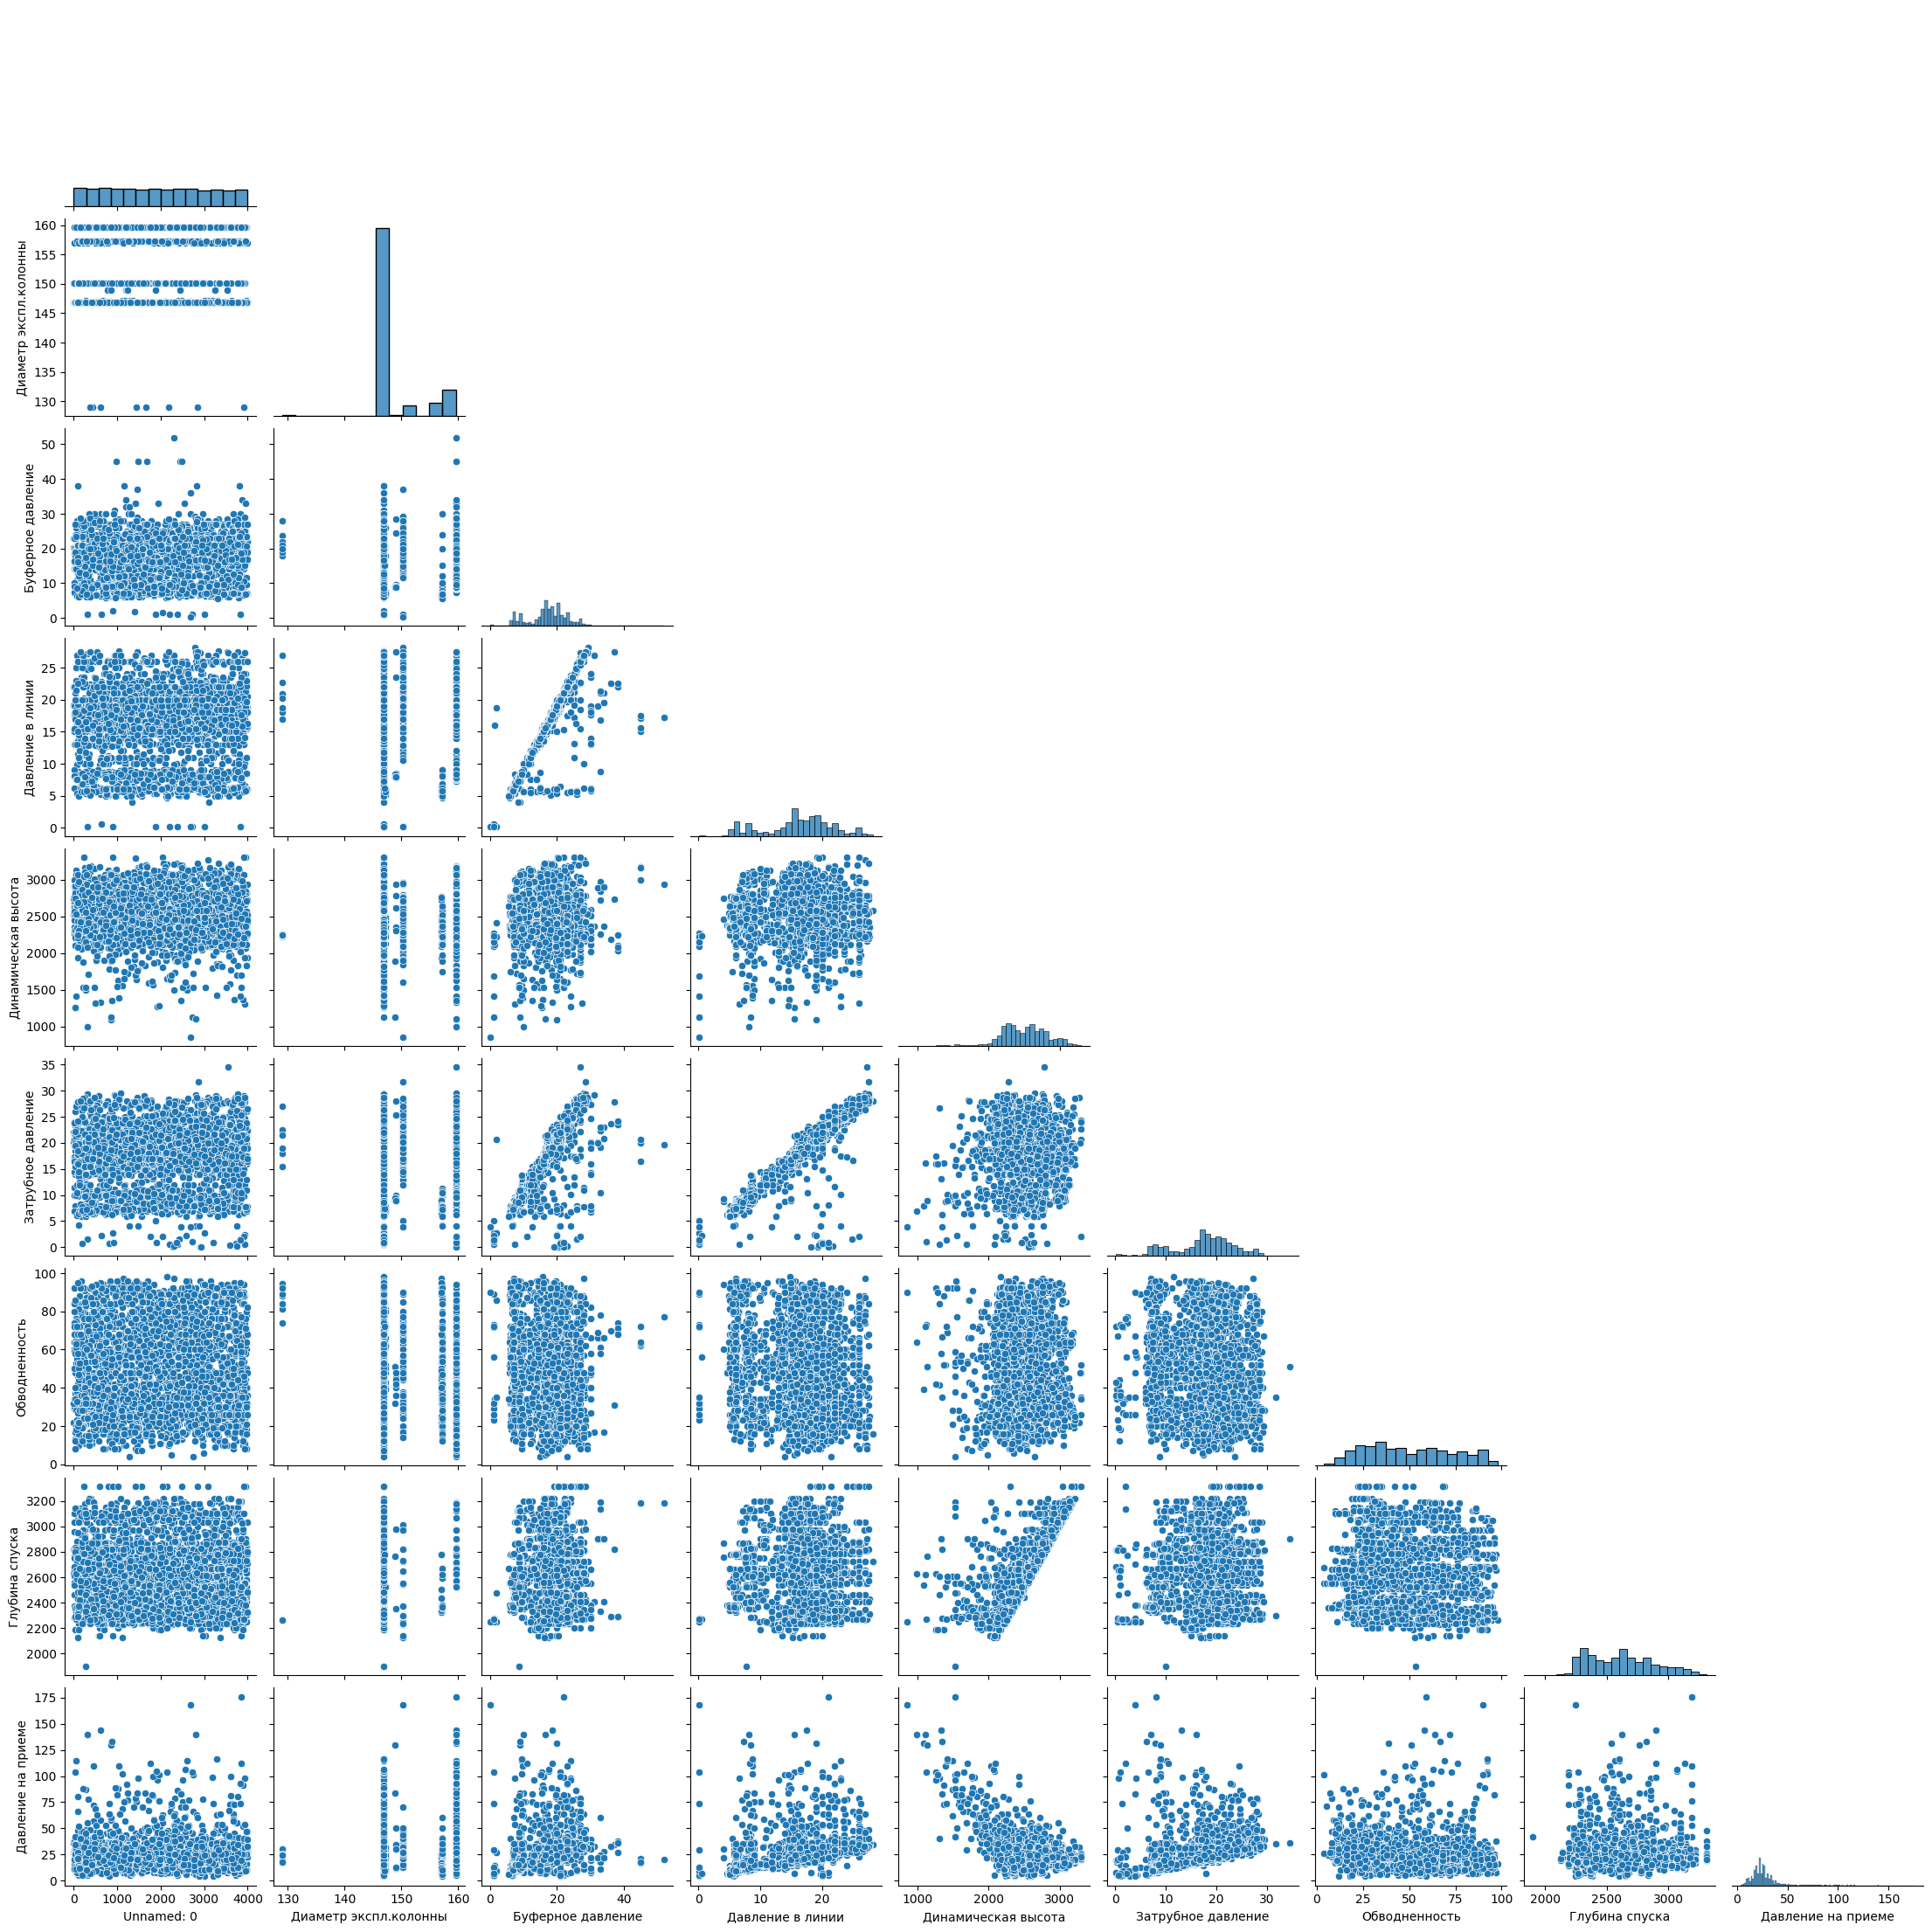

In [51]:
sns.pairplot(df_train, corner=True)

#### Построение матрицы корреляций

<AxesSubplot: >

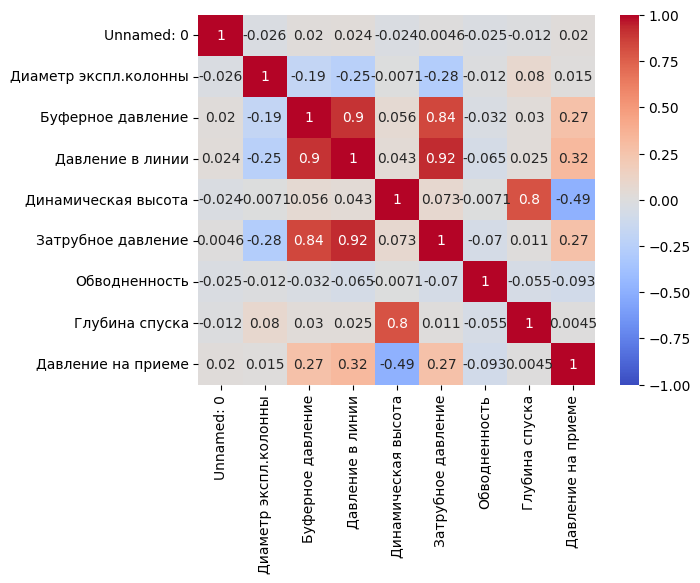

In [52]:
sns.heatmap(df_train.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Шаг 4. Построение модели

### Модель 1. Линейная регрессия со всеми признаками


In [56]:
selected_features = ['Диаметр экспл.колонны', 'Буферное давление', 'Давление в линии', 'Динамическая высота', 'Затрубное давление', 'Обводненность', 'Глубина спуска']
x = df_train[selected_features]
y = df_train['Давление на приеме']
best_model_reg = LinearRegression().fit(x, y)
y_predict = best_model_reg.predict(x)

print("Train R^2:", r2_score(y_predict, y.to_numpy()))
x = df_valid[selected_features]
y = df_valid['Давление на приеме']
y_predict = best_model_reg.predict(x)
print()
print("Valid R^2:", r2_score(y_predict, y.to_numpy()))

Train R^2: 0.742346833907968

Valid R^2: 0.6627360568209681


### Модель 2. Случайный лес

In [57]:
x = df_train[selected_features]
y = df_train['Давление на приеме']
best_model_rf = RandomForestRegressor(max_depth=100, random_state=0).fit(x, y)
y_predict = best_model_rf.predict(x)

print("Train R^2:", r2_score(y_predict, y.to_numpy()))
x = df_valid[selected_features]
y = df_valid['Давление на приеме']
y_predict = best_model_rf.predict(x)
print()
print("Valid R^2:", r2_score(y_predict, y.to_numpy()))

Train R^2: 0.9734488060377428

Valid R^2: 0.7856239830426661


### Модель 3. Градиентный бустинг

In [55]:
x = df_train[selected_features]
y = df_train['Давление на приеме']
best_model_gb = GradientBoostingRegressor(random_state=0).fit(x, y)
y_predict = best_model_gb.predict(x)

print("Train R^2:", r2_score(y_predict, y.to_numpy()))
x = df_valid[selected_features]
y = df_valid['Давление на приеме']
y_predict = best_model_gb.predict(x)
print()
print("Valid R^2:", r2_score(y_predict, y.to_numpy()))

Train R^2: 0.8939835875549639

Valid R^2: 0.7962279888087785


# Сохранение моделей

In [15]:
import joblib

In [34]:
joblib.dump(best_model_reg, "models/best_model_reg.pkl")
joblib.dump(best_model_svr, "models/best_model_svr.pkl")
joblib.dump(best_model_rf, "models/best_model_rf.pkl")
joblib.dump(best_model_gb, "models/best_model_gb.pkl")

['models/best_model_gb.pkl']